In [1]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from numpy import genfromtxt
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import load_sample_images
from tensorflow.python.keras.utils import to_categorical

In [2]:
# using opencv python for the Gabor filters
import cv2

Using tensorflow version 1.5

In [3]:
tf.__version__

'1.5.0'

## 1. Reading images and exploring data

In [4]:
# read the csv grayscale pixels
data=pd.read_csv('image_sentiment/sentiment_data.csv')

In [5]:
# converting all the strings of  pixels to numpy arrays with the right shape
data['feature']=data.feature.apply(lambda x: np.array(list(map(float,x.split()))).reshape(48,48))

In [6]:
len(data)

28709

In [7]:
# retrieving the names of the classes for visual confimation
sentiment_names=['angry', 'disgust', 'fear', 'happy','sad', 'surprise','neutral']

4
sad


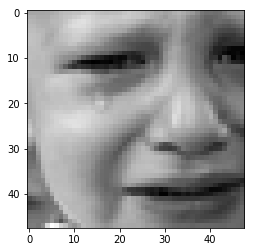

In [8]:
# printing any image with numeric and string label
i=580
plt.imshow(data.feature[i],cmap='gray')
print(data.label[i])
print(sentiment_names[int(data.label[i])])

In [9]:
data.label.value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: label, dtype: int64

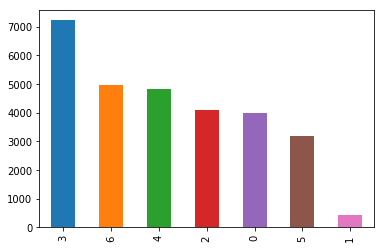

In [10]:
# getting all the numbers of images per class
data.label.value_counts().plot(kind='bar')

The examples for the classes 3 and 1 are imbalanced. I will perform the data augmentation so these classes would be balanced as the others are.

## 2. Preprocesing step

### 2.1. Dividing dataset for augmentation of certain classes

In [11]:
# method to crop images randomly
def random_crop(dataset, percentage):
    # adjusting cropping size  to the new image percentage and setting random seed
    crop_size = np.array([1,int(48*percentage),int(48*percentage)], dtype = np.int32)
    seed = np.random.randint(1234)

    X_cropped_data = []
    tf.reset_default_graph()
    X2 = tf.placeholder(tf.float32, shape=(1,48,48))
    # Define Tensorflow operation for all crops but only one base image at the time
    tf_img = tf.random_crop(X2, size = crop_size, seed = seed)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for img_data in dataset:
            batch_img = np.expand_dims(img_data, axis = 0)
            cropped_imgs = sess.run(tf_img, feed_dict = {X2: batch_img})
            X_cropped_data.extend(cropped_imgs)

#     X_cropped_data = np.array(X_cropped_data, dtype = np.float32)
    return X_cropped_data

In [12]:
# group images by label
groups = data.groupby(['label'])

If  the label is  equal to 3 just crop once, if not crop randomly many times until it reaches a good number

In [13]:
per=0.85 # setting the cropping value to the same percentage for all images
full_dataset=[]
labels=[]
for label, data_split in groups:
    dataset=np.array(data_split.feature.tolist(),dtype=np.float32)
    random_imgs = random_crop(dataset,per)
    full_dataset.extend(random_imgs)
    labels.extend(np.full(len(dataset),int(label)))

    if int(label)==3:
        continue
    elif int(label)==1:
        for i in range(0,10):
            random_imgs = random_crop(dataset,per)
            full_dataset.extend(random_imgs)
        labels.extend(np.full(10*len(dataset),int(label)))
    else:           
        dataset=np.array(data_split.feature[500:2500].tolist(),dtype=np.float32)
        random_imgs = random_crop(dataset,per)
        full_dataset.extend(random_imgs)
        labels.extend(np.full(len(dataset),int(label)))

### 2.2. Print a set of images originals and cropped

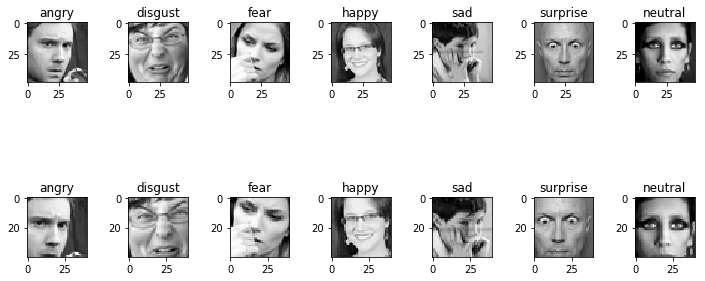

In [14]:
f, axarr = plt.subplots(2,7, figsize=(10,5))
f.tight_layout()
indexes=[0,299,2,7,3,15,4]
indexes_new=[0,5995,10791,16888,24103,30933,36104]
for i in range (0,2):
    for j in range(0,7):
        if i==0:
            axarr[i,j].imshow(data.feature[indexes[j]], cmap='gray')   
            axarr[i,j].set_title(sentiment_names[data.label[indexes[j]]])
        else:
            axarr[i,j].imshow(full_dataset[indexes_new[j]], cmap='gray')   
            axarr[i,j].set_title(sentiment_names[labels[indexes_new[j]]])

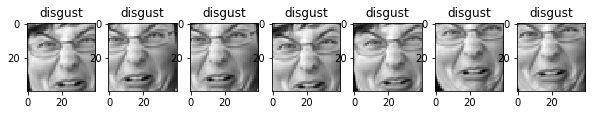

In [15]:
# augmentation of the class 1 = disgust
f, axarr = plt.subplots(1,7, figsize=(10,5))
indexes=[5995,6431,6867,7303,7739,8175,8611]

for j in range(0,7):
        axarr[j].imshow(full_dataset[indexes[j]], cmap='gray')   
        axarr[j].set_title(sentiment_names[labels[indexes[j]]])

### 2.3. Check for data augmentation result and label hot encoding

In [16]:
# #release memory from previous variables
del data
del groups
# #convert the cropped/ augmented result into a dataframe
data = pd.DataFrame({'label':labels,'feature':full_dataset})

In [17]:
# size of the augmented data
len(data)

43069

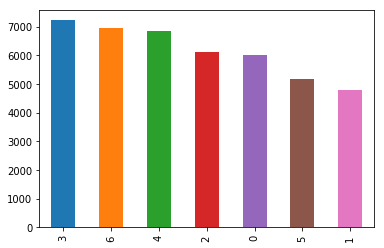

In [18]:
# plot of the distribution of the images per label
data.label.value_counts().plot(kind='bar')

- The bar graph above shows that the clases are much better due to the data augmentation
- Before splitting the data I will transform the labels to one hot encoding 

In [ ]:
# hot encoding labels
data=pd.concat([data, pd.get_dummies(data['label'],prefix='labl',drop_first=True)],axis=1)

In [ ]:
data.head()

,feature,label,labl_1,labl_2,labl_3,labl_4,labl_5,labl_6
0,"[[54.0, 58.0, 60.0, 48.0, 89.0, 115.0, 121.0, ...",0,0,0,0,0,0,0
1,"[[161.0, 174.0, 150.0, 127.0, 136.0, 140.0, 15...",0,0,0,0,0,0,0
2,"[[18.0, 25.0, 30.0, 32.0, 54.0, 85.0, 90.0, 10...",0,0,0,0,0,0,0
3,"[[149.0, 217.0, 231.0, 235.0, 236.0, 230.0, 23...",0,0,0,0,0,0,0
4,"[[46.0, 52.0, 62.0, 72.0, 70.0, 71.0, 73.0, 76...",0,0,0,0,0,0,0


## 3. Split into a test and training set (stratified by label)

### 3.1 Stratified split by label

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
#splitting the data into 80%train set and 20% test set
split= StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data['label']):
    data_train=data.loc[train_index]
    data_test=data.loc[test_index]

In [ ]:
# confirm that the numbers add up to 43069
print(len(data_train), "train +", len(data_test), "test")

34455 train + 8614 test


In [ ]:
# percentage of images in each class of the original cropped images
data['label'].value_counts()/len(data)

3    0.167522
6    0.161717
4    0.158583
2    0.141564
0    0.139195
5    0.120063
1    0.111356
Name: label, dtype: float64

In [ ]:
# percentage of images in each class of the stratified train set
data_train['label'].value_counts()/len(data_train)

3    0.167523
6    0.161718
4    0.158584
2    0.141547
0    0.139196
5    0.120070
1    0.111363
Name: label, dtype: float64

In [ ]:
# percentage of images in each class of the stratified test set
data_test['label'].value_counts()/len(data_test)

3    0.167518
6    0.161713
4    0.158579
2    0.141630
0    0.139192
5    0.120037
1    0.111330
Name: label, dtype: float64

## 4. Creating a CNN with three hidden layers

I will create a CNN using the following architecture:
    1. Convolutional layer # 1: convolution 32 gabor filters 5x5 with relu activation function
    2. Pooling layer # 1: maxpooling filter size 2x2 with stride of 2
    3. Fully connected layer # 1: 128 neurons relu activation function
    4. Fully connected layer # 2: 7 neurons softmax activation function (7 outputs one for each class)

In [ ]:
# using gabor filters was proven to be a good method in face feature detection
def get_Gabor_filters():
    filters = []
    ksize = 5
    for theta in np.arange(np.pi/8, np.pi, np.pi / 8):
        for lamda in np.arange(np.pi/4, np.pi, np.pi/4): 
            kern = cv2.getGaborKernel((ksize, ksize), 1.0, theta, lamda, 0.5, 0, ktype=cv2.CV_32F)
            kern /= 1.5*kern.sum()
            filters.append(kern)
    return filters

In [ ]:
height=40
width=40
channels=1

#setting placeholders
X = tf.placeholder(tf.float32, shape=[None, 40*40], name="X")
X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
y = tf.placeholder(tf.int32, shape=[None], name="y")

# generate 21 Gabor filters using opnecv 
filters_test=np.array(get_Gabor_filters(),dtype=np.float32)
filters_test=np.expand_dims(filters_test,1)
filters_test=filters_test.transpose(2,3,1,0)

#--------------------------CONVOLUTIONAL NETWORK --------------------------------

# Convloutional # 1: graph with input X plus a convolutional layer applying the 21 filters
conv1 = tf.nn.conv2d(X_reshaped ,filters_test,strides=[1,1,1,1], padding='SAME')
out_act=tf.nn.relu(conv1)

# Convolutional # 2: 
conv2 = tf.layers.conv2d(out_act, filters=32, kernel_size=3,strides=1, padding='SAME',
                               activation=tf.nn.relu, name="conv1")
# Max pool # 1
max_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
pool_flat = tf.reshape(max_pool, shape=[-1, 32*20*20])

# fully connected layer # 1
fc1 = tf.layers.dense(pool_flat, 64, activation=tf.nn.relu, name="fc1")

# fully connected layer # 2
logits = tf.layers.dense(fc1, 7, name="output")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

# optimizer
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)

# Calculate correct values and accuracy
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

# initizialize variables
init = tf.global_variables_initializer()
saver = tf.train.Saver()

## 5. Test the convolutional network

I chose crossentropy  to measure the loss and optimized it, the metric calculated to confirm the results is accuracy.

In [ ]:
train_imgs=np.array(data_train.feature.tolist(),dtype=np.float32)
test_imgs=np.array(data_test.feature.tolist(),dtype=np.float32)
train_labels=np.array(data_train.label.tolist(),dtype=np.float32)
test_labels=np.array(data_test.label.tolist(),dtype=np.float32)
X_train = train_imgs.astype(np.float32).reshape(-1, 40*40) / 255.0
X_test = test_imgs.astype(np.float32).reshape(-1, 40*40) / 255.0
y_train = train_labels.astype(np.int32)
y_test =test_labels.astype(np.int32)

In [ ]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [ ]:
n_epochs = 10
batch_size = 75

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)
        save_path = saver.save(sess, "./face_sentiment_model")

0 Last batch accuracy: 0.29333332 Test accuracy: 0.295101
1 Last batch accuracy: 0.34666666 Test accuracy: 0.35639656
2 Last batch accuracy: 0.36 Test accuracy: 0.3850708
3 Last batch accuracy: 0.5466667 Test accuracy: 0.39493847
4 Last batch accuracy: 0.58666664 Test accuracy: 0.39493847
5 Last batch accuracy: 0.68 Test accuracy: 0.3933132
6 Last batch accuracy: 0.7733333 Test accuracy: 0.39389366
7 Last batch accuracy: 0.6533333 Test accuracy: 0.3815881
8 Last batch accuracy: 0.74666667 Test accuracy: 0.36846992
9 Last batch accuracy: 0.85333335 Test accuracy: 0.3761319


### 5.1 Describing results 

The accuracy of the model is going up during the training stage, but it is performing bad on the test set.
I tuned some parameters as for example, the size of the Gabor filters to 3. Then I changed the convolutional layer to 32 tensorflow filters. Then I added an extra convolutional layer with 32 filters. None of these tuning strategies improved the results.

- 0 Last batch accuracy: 0.29333332 Test accuracy: 0.295101
- 1 Last batch accuracy: 0.34666666 Test accuracy: 0.35639656
- 2 Last batch accuracy: 0.36 Test accuracy: 0.3850708
- 3 Last batch accuracy: 0.5466667 Test accuracy: 0.39493847
- 4 Last batch accuracy: 0.58666664 Test accuracy: 0.39493847
- 5 Last batch accuracy: 0.68 Test accuracy: 0.3933132
- 6 Last batch accuracy: 0.7733333 Test accuracy: 0.39389366
- 7 Last batch accuracy: 0.6533333 Test accuracy: 0.3815881
- 8 Last batch accuracy: 0.74666667 Test accuracy: 0.36846992
- 9 Last batch accuracy: 0.85333335 Test accuracy: 0.3761319

## 6. Transfer Lerning with keras

In [ ]:
from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam, RMSprop


In [ ]:
### Preparing data to use with pretrained keras model

In [ ]:
data=pd.read_csv('image_sentiment/sentiment_data.csv')
# reshape image array
data['feature']=data.feature.apply(lambda x: np.array(list(map(float,x.split()))).reshape(48,48))
# repeat daya along axis to create a 3 channel image
data['feature']=data.feature.apply(lambda x: np.stack((x,)*3, axis=-1))

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
#splitting the data into 80%train set and 20% test set
split= StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data['label']):
    data_train=data.loc[train_index]
    data_test=data.loc[test_index]

In [ ]:
train_imgs=np.array(data_train.feature.tolist(),dtype=np.float32)
test_imgs=np.array(data_test.feature.tolist(),dtype=np.float32)
train_labels=np.array(data_train.label.tolist(),dtype=np.float32)
test_labels=np.array(data_test.label.tolist(),dtype=np.float32)
X_train = train_imgs.astype(np.float32).reshape(-1, 48,48,3) / 255.0
X_test = test_imgs.astype(np.float32).reshape(-1, 48,48,3) / 255.0
y_train = train_labels.astype(np.int32)
y_test = test_labels.astype(np.int32)

In [ ]:
y_encoded=to_categorical(y_train)

### 6.1. Model: VGG16

### 6.1 Structure of the model 

- The VGG16 model has 5 convolution blocks, each one of them followed by one maxPooling layer. Each convolution block performs two or three convolutions with the double of filters of the previous block. After this structure the output of the block5 maxpooling  is flattened and passed through a fully connected layer and then to the fully connected output.
- I will freeze all layers of all five blocks and I will use the output of the block5_maxpool as input of the new model.
- I changed the input to minimum accpeted 48x48 and I repeated the grayscale image along the three channels because the input accpeted must have three channels.
- I flattened the output of the maxpooling block and connected to a new fully connected layer with 128 neurons. I added a dropout layer to minimize overfitting. I added the last fully connected layer with 7 neurons for the 7 classes output propbability.

In [ ]:
# instanciate the model with the desired output (48x48x3)
model = VGG16(include_top=False, input_shape=(48,48,3),weights='imagenet')

In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [ ]:
tlearning_layer=model.get_layer('block5_pool')
tlearning_layer.output

<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 1, 1, 512) dtype=float32>

In [ ]:
before_bottleneck=Model(inputs=model.input, outputs= tlearning_layer.output)

### 6.1.1.Building a new model after the bottleneck to process my data

In [ ]:
my_model=Sequential()

# add the model before the bottleneck
my_model.add(before_bottleneck)

# Flatten the output to connect to the dense layer
my_model.add(Flatten())

# add a fully connected layer with 128 neurons, activation 'relu'
my_model.add(Dense(128, activation='relu'))

# add a dropout layer to avoid overfitting
my_model.add(Dropout(0.3))

# Add the layer with the outputs
my_model.add(Dense(7,activation='softmax'))

# set optimizer to Adam optimizer with slow training rate
optimizer= Adam(lr=1e-5)

In [ ]:
# defining loss and metric to calculate estimation 
loss='categorical_crossentropy'
metrics=['accuracy']

In [ ]:
# freeze all layers previous to the bottleneck
before_bottleneck.trainable=False

In [ ]:
# compile the method with the optimizer and metrics
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


## 7. Try the model on the training set

I used the categorical crossentropy to measure loss because it performs better when applying to classification problems,
I used the accuracy as a mesure of performance.

In [ ]:
# parameters for training
epochs=20
steps_per_epoch=100

In [ ]:
history=my_model.fit(X_train,y_encoded, batch_size=100,epochs=epochs,shuffle=True)

Epoch 1/20
22967/22967 [==============================]22967/22967 [==============================] - 552s 24ms/step - loss: 1.9905 - acc: 0.2243

Epoch 2/20
21800/22967 [===========================>..]21800/22967 [===========================>..] - ETA: 28s - loss: 1.9271 - acc: 0.2173

I couldn't run more than two epochs because my RAM was full. I didn't want to risk my processor